Lest start by importing spyro. You need to be inside the Firedrake venv for spyro to work

In [1]:
import spyro

Spyro uses a dictionary for all user defined variables

In [2]:
model = {}


Right now spyro works with 2D and 3D elements, using mass-lumped higher order (2 to 5 in 2d, 2 and 3 in 3d) elements, Lagrange elements (any order) and spectral quadrilateral elements with GLL nodes (any order)

In [3]:

model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV",  # Equi or KMV
    "degree": 4,  # p order
    "dimension": 2,  # dimension
}


Right now let's stick with spatial paralellism. We also support ensemble parallelism and we can do parallelism with different source numbers per core. However, this last feature is not yet automatically supported so you would have to set it up manually

In [4]:
model["parallelism"] = {
    "type": "spatial",
}


Mesh data is also part of the dictionary. 

In [5]:
model["mesh"] = {
    "Lz": 12.0,  # depth in km - always positive
    "Lx": 67.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "meshes/heterogeneous.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "velocity_models/bp2004.hdf5",
}


The BCs parameters also deal with the PML layer.

In [6]:
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}


Some details in this next section are going to be discontinued in the near future. For example there's no need to name the number of sources and receivers since we can count them in the list provided.

In [7]:
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 1,
    "source_pos": [(-0.1,67.0/2.0)],
    "frequency": 5.0,
    "delay": 1.0,
    "num_receivers": 20,
    "receiver_locations": spyro.create_transect((-5.0, 67.0/2.0-5.0), (-5.0, 67.0/2.0+5.0), 20),
}


In case you need help defining the maximum stable dt for a problem we can use the provided tools package

In [8]:
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 5.00,  # Final time for event
    "dt": 0.001,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
}

Now that the user defined varibles are out of the way we can actually use spyro. Before anything else we need to build the MPI communicator and read both the mesh and provided velocity model.

In [9]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
vp = spyro.io.interpolate(model, mesh, V, guess=False)

INFO: Distributing 1 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 34503 elements and can access 17658 vertices
INFO: converting from m/s to km/s


We also need to find the sources and receivers in the mesh. Even if you plan on using source encoding or a supershot this only needs to be ran once and already saves all the operatores needed for source injection and receiver interpolation. 

In [10]:
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

Our sources class only has the operators and source locations but doesn't define the source's scalar value over time. This can be done individually for each source or we can define them all right now:

In [11]:
wavelet = spyro.full_ricker_wavelet(
    dt=model["timeaxis"]["dt"],
    tf=model["timeaxis"]["tf"],
    freq=model["acquisition"]["frequency"],
)

Now all we have to do is call the forward solver method which return the full pressure wavefield (which we might have to use on gradient calculation) and the recorded pressure on our receivers (that we can use for our cost funcitonal)

In [12]:
p, p_r = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)

Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds
Simulation time is:     0.9995 seconds
Simulation time is:       1.05 seconds
Simulation time is:      1.099 seconds
Simulation time is:      1.149 seconds
Simulation time is:        1.2 seconds
Simulation time is:       1.25 seconds
Simulation time is:      

Spyro also has output functions so we can see our solution

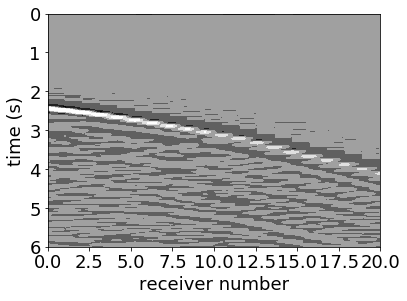

In [13]:
spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-3, vmax=1e-3, show=True)
spyro.io.save_shots(model, comm, p_r)